In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.stats import binom, norm, truncnorm

In [2]:
# we only need to define this once
def calc_L90_L50(dx, dy, fx):
        fx_flat = np.ravel(fx).copy()
        fx_flat.sort()
        fx_flat[:] = fx_flat[::-1]
        cdf = np.cumsum(fx_flat)*dx*dy
        cdf /= max(cdf)
        nearest_90 = np.argmin(abs(cdf-0.9))
        nearest_50 = np.argmin(abs(cdf-0.5))
        l90 = fx_flat[nearest_90]
        l50 = fx_flat[nearest_50]
        lmax = fx_flat[0]
        return lmax, l50, l90 

# Model Selection

## Bayes Factors
Let's say we didn't know for sure that the signal in the Gaussian data that we analyzed yesterday was a line, and we thought there was also a possibility that it might be sine wave.

In [3]:
# First, we define our "signal model", in this case a simple linear function
def line(time, m, c):
    return time * m + c

def sine(time, A, c):
    return np.sin(A*time) + c

In [4]:
# Now we define the injection parameters which we make simulated data with
injection_parameters = dict(m=0.5, c=0.2)

# For this example, we'll inject standard Gaussian noise
sigma = 1

# These lines of code generate the fake data. Note the ** just unpacks the
# contents of the injection_parameters when calling the model function.
sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
M = len(time)
# Set the seed for reproducibility
np.random.seed(1995)
data = line(time, **injection_parameters) + np.random.normal(0, sigma, M)

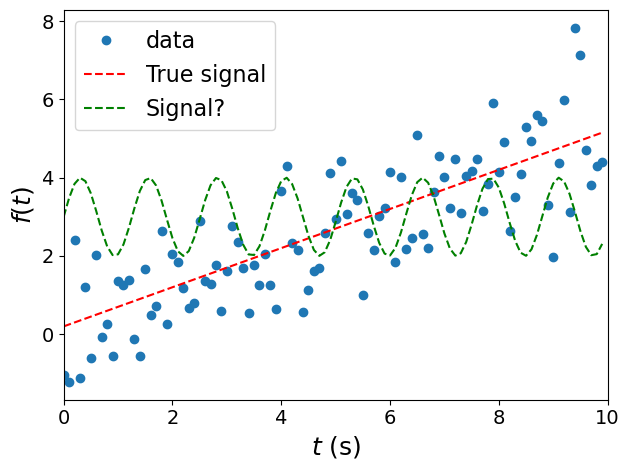

In [5]:
# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, line(time, **injection_parameters), "--r", label="True signal")
ax.plot(time, sine(time, A=5, c=3), "--g", label="Signal?")
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("$t$ (s)", fontsize=18)
ax.set_ylabel("$f(t)$", fontsize=18)
ax.set_xlim(0,10)
ax.legend(fontsize=16)
plt.tight_layout()

How do we quantify which model provides a better fit? We use Bayesian model comparison to compute the Bayes factor between the two models:
$$ \mathrm{BF}^{A}_{B} = \mathcal{Z}_{A}/\mathcal{Z}_{B}$$
Generally, log Bayes factors > 8 are considered significant evidence in favor of one model over the other [[Jeffreys (1961)](https://global.oup.com/academic/product/theory-of-probability-9780198503682?cc=us&lang=en&)]. We already calculated the evidence under the linear model in the previous lecture when we normalized the posterior, $\ln\mathcal{Z}=-151.78$. Now, we need to calculate the posteriors on the free parameters of the sine model to determine which is a better fit.

In [6]:
# define likelihood
def likelihood_sine(data, time, A, c, sigma):
    likelihood_arr = 1./np.sqrt(2*np.pi*sigma**2)*np.exp(-(data - sine(time, A, c))**2/(2*sigma**2))
    return np.prod(likelihood_arr)

In [7]:
# setup priors
As = np.linspace(0.3, 10, 100)
cs = np.linspace(1, 4, 99)
dA = As[1]-As[0]
dc = cs[1]-cs[0]
prior_A = 1./(As[-1]-As[0])
prior_c = 1./(cs[-1]-cs[0])

In [8]:
# calculate likelihood on a grid
likelihoods_sine = []
for A in As:
    for c in cs:
        likelihoods_sine.append(likelihood_sine(data, time, A, c, 1))
likelihoods_sine = np.array(likelihoods_sine).reshape(len(As), len(cs))

In [9]:
# calculate posterior and evidence
posterior_sine = likelihoods_sine*prior_A*prior_c
norm_sine = np.trapz(np.trapz(posterior_sine, cs, axis=1), As)
posterior_sine /= norm_sine
print(np.log(norm_sine))

-259.407042174785


#### Corner plot

In [10]:
# calculate marginalized 1D posteriors
post_A = np.trapz(posterior_sine, cs, axis=1)
post_c = np.trapz(posterior_sine, As, axis=0)

In [11]:
# calculate 50 and 90% credible levels
lmax, l50, l90 = calc_L90_L50(dA, dc, posterior_sine)

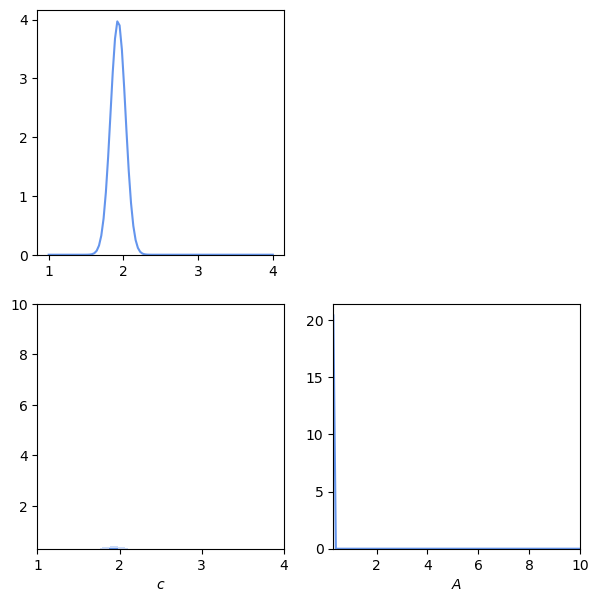

In [12]:
fig, axes = plt.subplots(2,2, figsize=(7,7))
axes[1,1].plot(As, post_A, color='cornflowerblue')
axes[1,1].set_ylim(0,)
axes[1,1].set_xlim(As[0], As[-1])
axes[0,0].plot(cs, post_c, color='cornflowerblue')
axes[0,0].set_ylim(0,)
axes[1,0].contourf(cs, As, posterior_sine, levels=[l90, l50, lmax], colors=['#CBDBF9', '#6495ED'])
axes[1,0].set_xlabel(r'$c$')
axes[1,1].set_xlabel(r'$A$')
axes[0,1].remove()

It seems like we didn't choose our prior ranges very sensibly, as the posterior on A peaks shaprly at the lower edge, so some probability is cut off. (Unphysical) prior railing is one indication of model misspecification that can be addressed by choosing a different prior range. How does this change our evidence?

In [13]:
As = np.linspace(0.05, 0.25, 100)
cs = np.linspace(1.5, 2.5, 99)
dA = As[1]-As[0]
dc = cs[1]-cs[0]
prior_A = 1./(As[-1]-As[0])
prior_c = 1./(cs[-1]-cs[0])

In [14]:
likelihoods_sine = []
for A in As:
    for c in cs:
        likelihoods_sine.append(likelihood_sine(data, time, A, c, 1))
likelihoods_sine = np.array(likelihoods_sine).reshape(len(As), len(cs))

In [15]:
posterior_sine = likelihoods_sine*prior_A*prior_c
norm_sine = np.trapz(np.trapz(posterior_sine, cs, axis=1), As)
posterior_sine /= norm_sine
print(np.log(norm_sine))

-219.38857331598152


We can see from the change in the evidence that the broader prior gives us a much better fit to the data. Is there still posterior "railing"?

In [16]:
post_A = np.trapz(posterior_sine, cs, axis=1)
post_c = np.trapz(posterior_sine, As, axis=0)

In [17]:
lmax, l50, l90 = calc_L90_L50(dA, dc, posterior_sine)

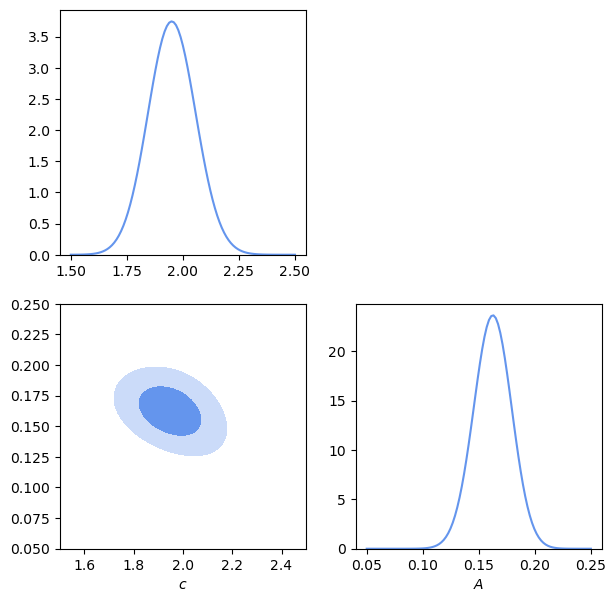

In [18]:
fig, axes = plt.subplots(2,2, figsize=(7,7))
axes[1,1].plot(As, post_A, color='cornflowerblue')
axes[1,1].set_ylim(0,)
axes[0,0].plot(cs, post_c, color='cornflowerblue')
axes[0,0].set_ylim(0,)
axes[1,0].contourf(cs, As, posterior_sine, levels=[l90, l50, lmax], colors=['#CBDBF9', '#6495ED'])
axes[1,0].set_xlabel(r'$c$')
axes[1,1].set_xlabel(r'$A$')
axes[0,1].remove()

Now let's see how well this inferred model matches our data. We'll come back to additional checks of model misspecification later.

In [19]:
maxp_ind = np.argmax(posterior_sine.ravel())
amax = As[maxp_ind//len(As)]
cmax = cs[maxp_ind%len(cs)]

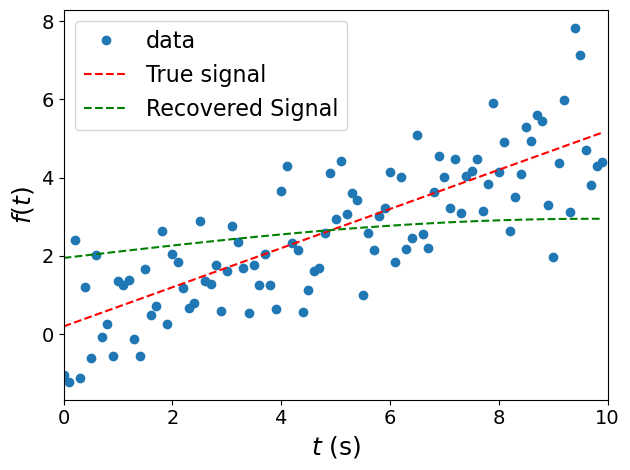

In [20]:
# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, line(time, **injection_parameters), "--r", label="True signal")
ax.plot(time, sine(time, A=amax, c=cmax), "--g", label="Recovered Signal")
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("$t$ (s)", fontsize=18)
ax.set_ylabel("$f(t)$", fontsize=18)
ax.set_xlim(0,10)
ax.legend(fontsize=16)
plt.tight_layout()

In [21]:
lnBF = -151.78 - np.log(norm_sine)
print(f'The linear model is preferred over the sine model with a ln Bayes Factor of {lnBF}')

The linear model is preferred over the sine model with a ln Bayes Factor of 67.60857331598152


We can see by eye that the sine model provides an inferior fit to the data, and the Bayes factor provides strong evidence in favor of the linear model. But what if we had doubled the width of the prior for the original inference of the parameters of the linear model? How would the evidence change?
$$\mathcal{Z} = \int p(d | m,c) p(m,c)dmdc$$
The likelihood doesn't change; it still strongly disfavors values of m,c outside the original narrow prior, but if the width of the prior is doubled, $$p_{\mathrm{wide}}(m,c) = 0.5p_{\mathrm{narrow}}(m,c)$$ in order for both priors to be properly normalized. This means the evidence decreases by a factor of 2, even though the posterior doesn't change at all! This highlight how Bayes Factors are strongly prior dependent, and thus must be taken with a grain of salt when disparate models are being compared.

## Bayesian Odds Ratios

The Bayes factor assumes that both hypotheses have equal prior odds - I believe a priori that the data would be equally well fit by either a line or a sine curve. This is pretty unusual in astrophysical scenarios - usually we have some theoretical preference for one model over the other. For example:

- I am fitting cosmological parameters from CMB data. I believe $\Lambda$CDM is more likely to be the "right" cosmological model than fuzzy, warm, or self-interacting dark matter.
- I am characterizing the black hole metric with EHT observations of supermassive black holes. I believe that General Relativity is more likely to be the "right" theory of gravity over Brans-Dicke theory or Chern-Simons Gravity.
- I am characterizing the merger of a massive compact-object binary with gravitational-wave observations. I belive that the component compact objects are more likely to be Kerr black holes over exotic compact objects like proca stars, naked singularities, gravastars, etc.

What are some examples from your research?

If we want to incorporate our prior knowledge of the likelihood of each hypothesis, we can calculate the odds ratio rather than the Bayes factor:
$$\mathcal{O}^{A}_{B} = \frac{\mathcal{Z}^{A}\mathcal{O}^{A}}{\mathcal{Z}^{B}\mathcal{O}^{B}},$$
where $\mathcal{O}^{A}$ are the prior odds of hypothesis A.

## Nested models: Occam's Razor and Savage-Dickey Ratio
Sometimes, we are interested in comparing nested models. Instead of fitting our data with a line (true model) we can fit it with a quadratic function, $d(f) = bt^2 + mt + c$, which reduces to the linear model if $b=0$:

In [22]:
# define quadratic model
def quadratic(time, b, m, c):
    return b*time**2 + m*time + c

In [23]:
# define quadratic likelihood
def likelihood_quad(data, time, b, m, c, sigma):
    likelihood_arr = 1./np.sqrt(2*np.pi*sigma**2)*np.exp(-(data - quadratic(time, b, m, c))**2/(2*sigma**2))
    return np.prod(likelihood_arr)

In [24]:
# setup priors
ms = np.linspace(-0.5, 1.5, 100)
bs = np.linspace(-0.1, 0.1, 101)
cs = np.linspace(-0.7, 1, 99)
dm = ms[1] - ms[0]
db = bs[1] - bs[0]
prior_m = 1./(ms[-1]-ms[0])
prior_c = 1./(cs[-1]-cs[0])
prior_b = 1./(bs[-1]-cs[0])

In [25]:
# This cell will take a couple seconds to run because we've increased the dimensionality
likelihoods_quad = []
for b in bs:
    for m in ms:
        for c in cs:
            likelihoods_quad.append(likelihood_quad(data, time, b, m, c, 1))
likelihoods_quad = np.array(likelihoods_quad).reshape(len(bs), len(ms), len(cs))

In [26]:
# calculate posterior and evidence
posterior_quad = likelihoods_quad*prior_b*prior_c*prior_m
norm_quad = np.trapz(np.trapz(np.trapz(posterior_quad, bs, axis=0), ms, axis=0), cs)
posterior_quad /= norm_quad
print(np.log(norm_quad))

-156.84502067893152


#### (3D) corner plot

In [27]:
# calculate marginalized 2D and 1D posteriors
post_mb = np.trapz(posterior_quad, cs, axis=2).T
post_mc = np.trapz(posterior_quad, bs, axis=0)
post_bc = np.trapz(posterior_quad, ms, axis=1)
post_m = np.trapz(post_mb, bs, axis=1)
post_b = np.trapz(post_mb, ms, axis=0)
post_c = np.trapz(post_mc, ms, axis=0)

In [28]:
# calculate 90 and 50% credible intervals for all 2D posteriors
lmax_mb, l50_mb, l90_mb = calc_L90_L50(dm, db, post_mb)
lmax_mc, l50_mc, l90_mc = calc_L90_L50(dm, dc, post_mc)
lmax_bc, l50_bc, l90_bc = calc_L90_L50(db, dc, post_bc)

In [29]:
injection_parameters['b'] = 0
posts_1d = [post_m, post_b, post_c]
inds_1d = [ms, bs, cs]
params = ['m', 'b', 'c']

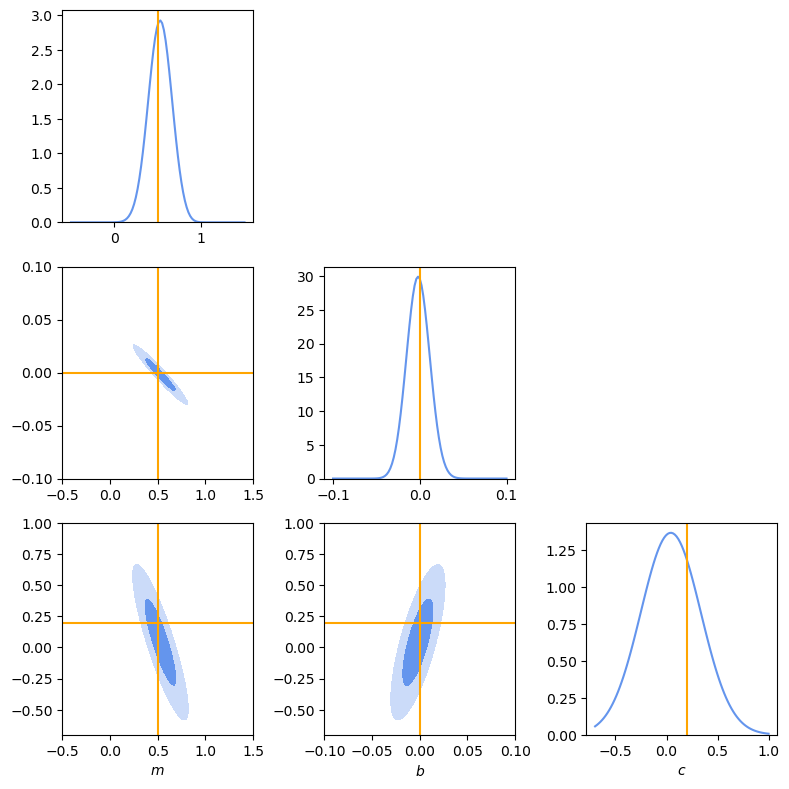

In [30]:
N=3
fig, axes = plt.subplots(N,N, figsize=(8,8))
axes_2d = [axes[1,0], axes[2,0], axes[2,1]]
for i, post in enumerate(posts_1d):
    axes[i,i].plot(inds_1d[i], posts_1d[i], color='cornflowerblue')
    axes[i,i].set_ylim(0,)
    axes[i,i].axvline(injection_parameters[params[i]], color='orange')
axes[1,0].contourf(ms, bs, post_mb.T, levels=[l90_mb, l50_mb, lmax_mb], colors=['#CBDBF9', '#6495ED'])
axes[2,0].contourf(ms, cs, post_mc.T, levels=[l90_mc, l50_mc, lmax_mc], colors=['#CBDBF9', '#6495ED'])
axes[2,1].contourf(bs, cs, post_bc.T, levels=[l90_bc, l50_bc, lmax_bc], colors=['#CBDBF9', '#6495ED'])
axes[1,0].axhline(injection_parameters['b'], color='orange')
axes[1,0].axvline(injection_parameters['m'], color='orange')
axes[2,0].axvline(injection_parameters['m'], color='orange')
axes[2,0].axhline(injection_parameters['c'], color='orange')
axes[2,1].axhline(injection_parameters['c'], color='orange')
axes[2,1].axvline(injection_parameters['b'], color='orange')
axes[2,2].set_xlabel(r'$c$')
axes[2,1].set_xlabel(r'$b$')
axes[2,0].set_xlabel(r'$m$')
for axis in [axes[0,1], axes[0,2], axes[1,2]]:
    axis.remove()
plt.tight_layout()

Let's compare the posteriors obtained on $m,c$ with the linear model, using the same prior that we chose for the quadratic model inference.

In [31]:
# define linear likelihood 
def likelihood_line(data, time, m, c, sigma):
    likelihood_arr = 1./np.sqrt(2*np.pi*sigma**2)*np.exp(-(data - line(time, m, c))**2/(2*sigma**2))
    return np.prod(likelihood_arr)

In [32]:
# calculate linear likelihood on a grid
likelihoods_line = []
for m in ms:
    for c in cs:
        likelihoods_line.append(likelihood_line(data, time, m, c, 1))
likelihoods_line = np.array(likelihoods_line).reshape(len(ms), len(cs))

In [33]:
# calculate linear posterior and evidence
posterior_line = likelihoods_line*prior_m*prior_c
norm_line = np.trapz(np.trapz(posterior_line, cs, axis=1), ms)
posterior_line /= norm_line
print(np.log(norm_line))

-153.68047116445845


#### Corner plot

In [34]:
post_m_line = np.trapz(posterior_line, cs, axis=1)
post_c_line = np.trapz(posterior_line, ms, axis=0)

In [35]:
lmax, l50, l90 = calc_L90_L50(dm, dc, posterior_line)

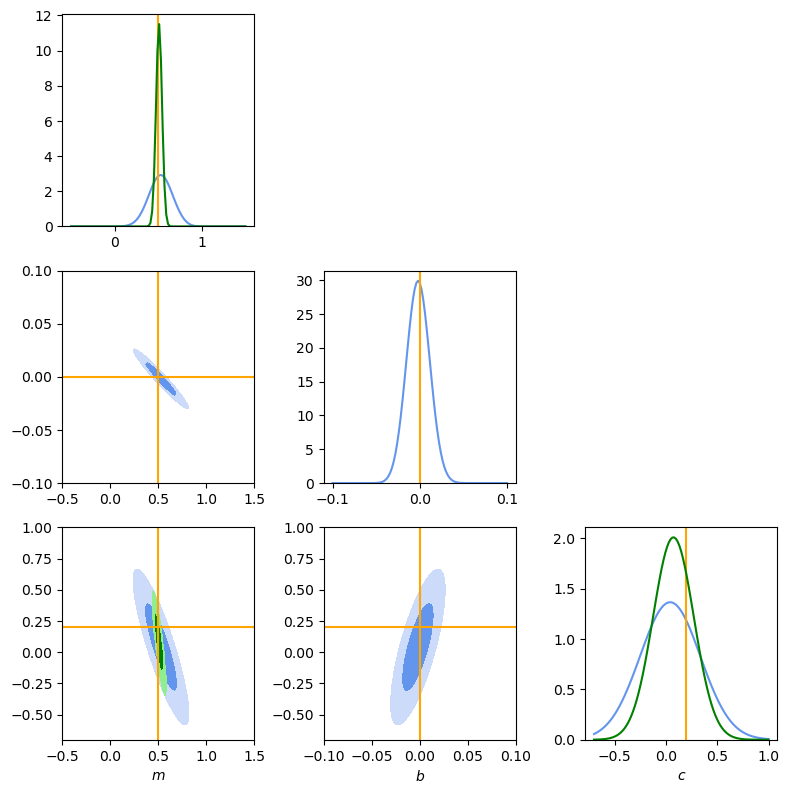

In [36]:
N=3
fig, axes = plt.subplots(N,N, figsize=(8,8))
axes_2d = [axes[1,0], axes[2,0], axes[2,1]]
for i, post in enumerate(posts_1d):
    axes[i,i].plot(inds_1d[i], posts_1d[i], color='cornflowerblue')
    axes[i,i].axvline(injection_parameters[params[i]], color='orange')
axes[1,0].contourf(ms, bs, post_mb.T, levels=[l90_mb, l50_mb, lmax_mb], colors=['#CBDBF9', '#6495ED'])
axes[2,0].contourf(ms, cs, post_mc.T, levels=[l90_mc, l50_mc, lmax_mc], colors=['#CBDBF9', '#6495ED'])
axes[2,1].contourf(bs, cs, post_bc.T, levels=[l90_bc, l50_bc, lmax_bc], colors=['#CBDBF9', '#6495ED'])
axes[1,0].axhline(injection_parameters['b'], color='orange')
axes[1,0].axvline(injection_parameters['m'], color='orange')
axes[2,0].axvline(injection_parameters['m'], color='orange')
axes[2,0].axhline(injection_parameters['c'], color='orange')
axes[2,1].axhline(injection_parameters['c'], color='orange')
axes[2,1].axvline(injection_parameters['b'], color='orange')
axes[2,2].set_xlabel(r'$c$')
axes[2,1].set_xlabel(r'$b$')
axes[2,0].set_xlabel(r'$m$')
for axis in [axes[0,1], axes[0,2], axes[1,2]]:
    axis.remove()
axes[0,0].plot(ms, post_m_line, color='green')
axes[2,2].plot(cs, post_c_line, color='green')
for i in range(N):
    axes[i,i].autoscale()
    axes[i,i].set_ylim(0,)
axes[2,0].contourf(ms, cs, posterior_line.T, levels=[l90, l50, lmax], colors=['lightgreen', 'green'])
plt.tight_layout()

We can see that the posteriors obtained under the quadratic model are broader. This increased uncertainty comes from introducing another free parameter to the model, whose inference is correlated with the m,c parameters. What if we looked at the slice of the full quadratic posterior for $b=0$, namely $p(m,c,b=0|\{d\})$

In [37]:
b0 = np.where(bs==0)[0]

In [38]:
post_b0 = posterior_quad[50,:,:]
norm_b0 = np.trapz(np.trapz(post_b0, cs, axis=1), ms)
post_b0 /= norm_b0

In [39]:
post_m_b0 = np.trapz(post_b0, cs, axis=1)
post_c_b0 = np.trapz(post_b0, ms, axis=0)

In [40]:
lmax_b0, l50_b0, l90_b0 = calc_L90_L50(dm, dc, post_b0)

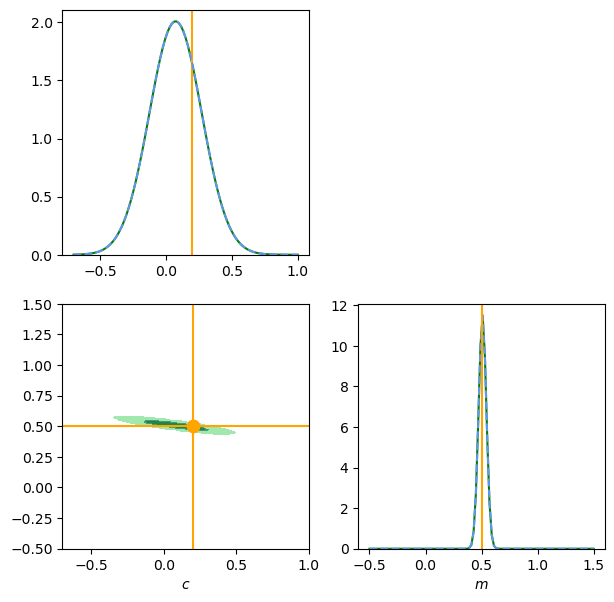

In [41]:
fig, axes = plt.subplots(2,2, figsize=(7,7))
axes[1,1].plot(ms, post_m_line, color='green')
axes[1,1].plot(ms, post_m_b0, color='cornflowerblue', ls='--')
axes[1,1].axvline(injection_parameters['m'], color='orange')
axes[1,1].autoscale()
axes[1,1].set_ylim(0,)
axes[1,1].set_xlabel(r'$m$')

axes[1,0].contourf(cs, ms, posterior_line, levels=[l90, l50, lmax], colors=['lightgreen', 'green'])
axes[1,0].contourf(cs, ms, post_b0, levels=[l90_b0, l50_b0, lmax_b0], colors=['#CBDBF9', '#6495ED'], alpha=0.3)
axes[1,0].set_xlabel(r'$c$')
axes[1,0].axvline(injection_parameters['c'], color='orange')
axes[1,0].axhline(injection_parameters['m'], color='orange')
axes[1,0].scatter(injection_parameters['c'], injection_parameters['m'], s=80, color='orange')

axes[0,0].plot(cs, post_c_line, color='green')
axes[0,0].axvline(injection_parameters['c'], color='orange')
axes[0,0].plot(cs, post_c_b0, color='cornflowerblue', ls='--')
axes[0,0].autoscale()
axes[0,0].set_ylim(0,)

axes[0,1].remove()

We are reassured that the posteriors obtained with the linear model lie exactly on top of those obtained with the quadratic model at $b=0$! How do the evidences compare? Let's calculate the Bayes Factor.

In [42]:
ln_BF_line_quad = np.log(norm_line) - np.log(norm_quad)
print(f'The linear model is preferred over the quadratic model with a ln Bayes Factor of {ln_BF_line_quad}')

The linear model is preferred over the quadratic model with a ln Bayes Factor of 3.164549514473066


### Occam's Razor
This is not a significant preference, but the linear model is preferred over the quadratic model. Why? In theory, both models should fit the data equally well. However, the linear model is the simplest model that accurately fits the data. The quadratic model is penalized by the Occam factor, which stems from Occam's Razor: the principle that a model should be no more complicated than exactly needed to describe some data. Let's look at another simple example from a seminal paper on Occam's penalty in Bayesian Inference [[Jeffreys and Berger (1991)](https://home.cs.colorado.edu/~mozer/Teaching/syllabi/6622/papers/JefferysBerger1991.pdf)].

### Example: Plagiarism in Numerical Tables
<img src="occams_razor_plagiarism.png" alt="test about plagiarism in numerical tables" width="800"/>
Now assume that we learn that another table has been published using the exact same rounding patter as our own. H0 is the hypothesis that the new table was plagiarized, and H1 is the hypothesis that the duplication is a random fluke. We assign equal prior probabilities to the two hypotheses.

**Likelihoods:** $P(D | H_0) = 1,\ P(D | H1)\approx 10^{-30}$   
**Posteriors:** $$\begin{align} 
P(H_0 | D) &= \frac{P(D | H_0)P(H_0)}{P(D | H_0)P(H_0) + P(D | H_1)P(H_1)}\\
&= \frac{1\times 0.5}{0.5 \times (1 + 10^{-30})} \approx 1\\
P(H_1 | D) &\approx 10^{-30}
\end{align}$$
We see that the simpler hypothesis is strongly preferred, and changing the prior probability would not have a significant effect due to the large differences of the likelihood of the data given the two hypotheses. H0 makes only one specific prediction and is trivially falsifiable, while H1 cannot be falsified; it's consistent with all data.

### Savage-Dickey Ratio

In the cases where our inference is computationally expensive, it becomes inconvenient to repeat it with two nested hypotheses in order to dintinguish which is preferred. Instead, we can use the Savage-Dickey Ratio to approximate the Bayes Factor between two nested hypotheses (see the [Book of Statistical Proofs](https://statproofbook.github.io/P/bf-sddr.html) for more details).

**Theorem:** Consider two competing models on data $d$ containing parameters $\delta$ and $\varphi$, namely $m_0:\delta=\delta_0,\varphi$ and $m_1:\delta,\varphi$. In this context, we say that $\delta$ is a parameter of interest, $\varphi$ is a nuisance parameter (i.e., common to both models), and $m_0$ is a sharp point hypothesis nested within $m_1$. Suppose further that the prior for the nuisance parameter $\varphi$ in $m_0$ is equal to the prior for $\varphi$ in $m_1$ after conditioning on the restriction – that is, $p(\varphi\mid m_0) = p(\varphi\mid \delta=\delta_0,m_1)$. Then the Bayes factor for $m_0$ over $m_1$ can be computed as:

$$\text{BF}_{01} = \frac{p(\delta=\delta_0\mid d,m_1)}{p(\delta=\delta_0\mid m_1)}$$
The Savage-Dickey Ratio allows us to calculate the Bayes Factor in favor of the simpler model as the ratio of the posterior probability to the prior probability at that point in parameter space using the posterior obtained using a more complex model. Let's try this out for out linear vs quadratic analysis:

In [43]:
post_b0_quad = post_b[b0]
savage_dickey = post_b0_quad/prior_b
print(np.log(savage_dickey))

[3.16454951]


In [44]:
ln_BF_line_quad/np.log(savage_dickey)

array([1.])

The Bayes factor we obtained by calculating the evidences is exactly equal to the Savage-Dickey ratio! This saves us some compute time when comparing nested models. 

## Model misspecification

There are several ways that Bayesian inference analyses can be affected by model misspecification:
- Prior: We already saw above an example of prior misspecification. Our initial prior on $A$ when fitting our data with the sine function was too narrow, so some prior probability was cut off on the lower edge. Sometimes, there are physical reasons to accept prior railing (i.e., the dimensionless spin of a black hole is bound between 0-1). Otherwise, the solution to this test of model misspecification is to broaden the range of the prior.

- Noise Model: For the examples we've seen so far, we have (correctly) assumed that our measurement noise is white ($\sigma=1$) and Gaussian. However, misspecifying the noise properties when writing down the likelihood can lead to biased inference. For example, we might assume Gaussian noise when really our measurements have noise that is [Student's-t distributed](https://en.wikipedia.org/wiki/Student%27s_t-distribution). Below, you will work on a problem to diagnose noise model misspecification.

- Signal Model: Above, we tried to fit data with a linear signal with a sine signal instead, and saw how the sine model provided a worse fit to the data than the linear model using Bayes factors. However, if we are not necessarily interested in comparing two competing models and just want to get a sense of whether a particular model provides an adequate fit to the data, we can test for model misspecification. Let's see how this works for the sine model example.

Most tests of model misspecification are visual. Let's take a look at one example. 
### Check the signal model

If the signal model provides a good fit to the data, the residuals ($d(t) - h(t; A, c)$) should be Gaussian distributed. To check this, we will plot the difference between the CDF of the residuals from the data and the theoretical CDF of the residuals as a function of the theoretical CDF. To capture the uncertainty in our measurement, we will do for this many samples from the posterior. If this plot is symmetric about 0, it indicates that the model provides a good fit to the data. Let's make this plot first for the linear fit.

In [45]:
# To do this without running a sampler, we will just use one dimension. Let's fit m and keep c fixed
ms = np.linspace(0.4, 0.6, 1000)
likelihood_m1d = []
for m in ms:
    likelihood_m1d.append(likelihood_line(data, time, m, injection_parameters['c'], 1))
posterior_m1d = np.array(likelihood_m1d)*prior_m

In [46]:
norm_m1d = np.trapz(posterior_m1d, ms)
posterior_m1d /= norm_m1d

We want to generate samples from the posterior so that we can encapsulate the uncertainty in our measurement of the parameter of interest when comparing the CDF of the residuals in our data to the expected CDF of the model. To do this, we use **inverse transform sampling**. We want to rescale random draws from the unit interval to our probability distribution. To do this, we use the inverse of the CDF:
$$ 
x \in [0,1]
m = CDF^{-1}(x)
$$
This works because the CDF takes on values between 0 and 1 for all values in the domain of our parameter of interest, so the inverse CDF provides a one-to-one mapping between draws from the unit cube to the physical space of our parameter. Inverse transform sampling provides a computationally cheap and convenient way to sample from *any* one-dimensional distribution. If we don't know the inverse CDF analytically (as is the case for our posterior distribution), we can use interpolation to fill in the unknown values between our grid points. Inverse transform sampling is what's used by any stochastic sampler to generate draws from the prior.

In [47]:
# generate samples
cdf_m1d = cumulative_trapezoid(posterior_m1d, ms, initial=0)
unit_cube_samples = np.random.rand(5000)
samples = np.interp(unit_cube_samples, cdf_m1d, ms)

(array([ 0.14307116,  0.09538077,  0.23845194,  0.23845194,  0.57228465,
         1.33533085,  2.90911363,  4.67365797,  6.0566792 ,  8.63196012,
        13.16254693, 14.16404506, 18.79001264, 20.41148582, 22.31910131,
        22.55755325, 20.64993775, 20.31610504, 17.40699141, 13.83021235,
        11.15955066,  7.43970044,  4.57827719,  3.19525596,  1.5260924 ,
         1.09687891,  0.52459426,  0.23845194,  0.09538077,  0.09538077]),
 array([0.42565866, 0.42985238, 0.43404609, 0.43823981, 0.44243353,
        0.44662725, 0.45082096, 0.45501468, 0.4592084 , 0.46340212,
        0.46759583, 0.47178955, 0.47598327, 0.48017698, 0.4843707 ,
        0.48856442, 0.49275814, 0.49695185, 0.50114557, 0.50533929,
        0.50953301, 0.51372672, 0.51792044, 0.52211416, 0.52630787,
        0.53050159, 0.53469531, 0.53888903, 0.54308274, 0.54727646,
        0.55147018]),
 [<matplotlib.patches.Polygon at 0x16b1eef50>])

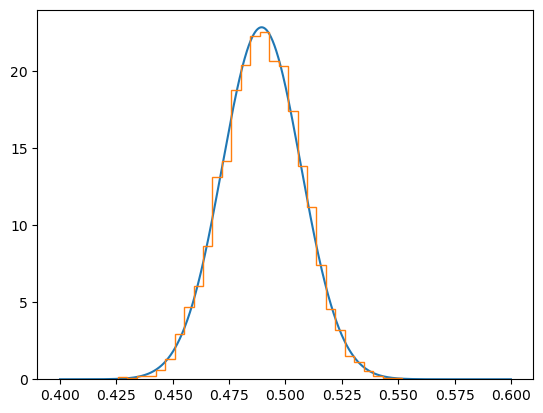

In [48]:
plt.plot(ms, posterior_m1d)
plt.hist(samples, density=True, histtype='step', bins=30)

Text(0, 0.5, 'data CDF - model CDF')

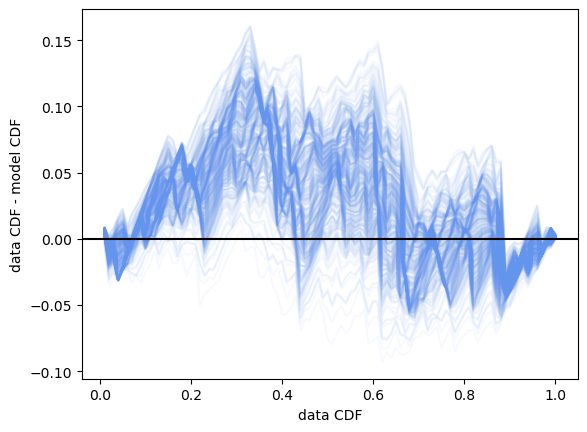

In [50]:
for i in samples[::10]:
    model = line(time, i, injection_parameters['c'])
    residual = data - model
    data_cdf = np.arange(1,len(residual)+1)/len(residual)
    model_cdf = norm.cdf(np.sort(residual))
    diff = data_cdf - model_cdf
    plt.plot(data_cdf, diff, color='cornflowerblue', alpha=0.05)
plt.axhline(0, color='k')
plt.xlabel('data CDF')
plt.ylabel('data CDF - model CDF')

In [51]:
# Fit A and keep c fixed to its maximum-posterior value from the run with both
likelihood_A1d = []
for A in As:
    likelihood_A1d.append(likelihood_sine(data, time, A, cmax, 1))
posterior_A1d = np.array(likelihood_A1d)*prior_A

In [52]:
norm_A1d = np.trapz(posterior_A1d, As)
posterior_A1d /= norm_A1d
cdf_A1d = cumulative_trapezoid(posterior_A1d, As, initial=0)

In [53]:
# generate samples
weights_A = posterior_A1d/np.sum(posterior_A1d)
samples_A = np.random.choice(As, size=5000, replace=True, p=weights_A)

(array([ 0.14142857,  0.09428571,  0.09428571,  0.33      ,  0.42428571,
         0.80142857,  2.54571429,  3.01714286,  4.76142857,  8.01428571,
        19.47      , 17.58428571, 20.93142857, 23.24142857, 24.70285714,
        21.49714286, 23.1       , 17.20714286, 14.66142857, 12.49285714,
        10.70142857,  4.10142857,  2.45142857,  1.65      ,  0.75428571,
         0.51857143,  0.14142857,  0.14142857,  0.        ,  0.14142857]),
 array([0.10050505, 0.10474747, 0.1089899 , 0.11323232, 0.11747475,
        0.12171717, 0.1259596 , 0.13020202, 0.13444444, 0.13868687,
        0.14292929, 0.14717172, 0.15141414, 0.15565657, 0.15989899,
        0.16414141, 0.16838384, 0.17262626, 0.17686869, 0.18111111,
        0.18535354, 0.18959596, 0.19383838, 0.19808081, 0.20232323,
        0.20656566, 0.21080808, 0.21505051, 0.21929293, 0.22353535,
        0.22777778]),
 [<matplotlib.patches.Polygon at 0x16c8a3e50>])

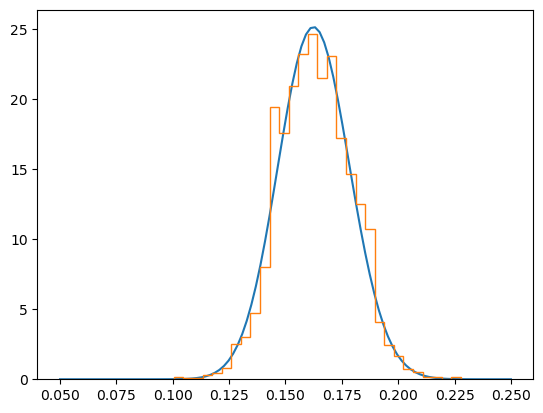

In [54]:
plt.plot(As, posterior_A1d)
plt.hist(samples_A, density=True, histtype='step', bins=30)

Text(0, 0.5, 'data CDF - model CDF')

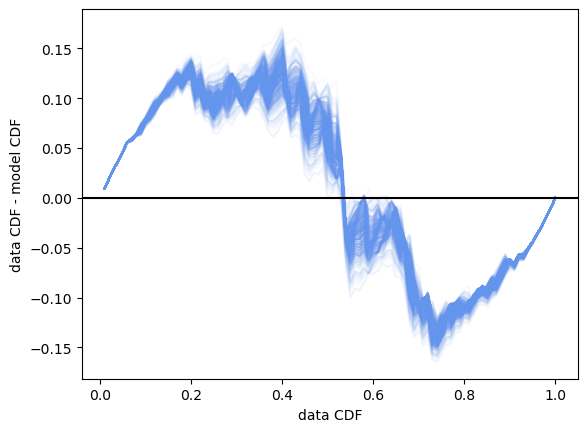

In [55]:
for i in samples_A[::10]:
    model = sine(time, i, cmax)
    residual = data - model
    data_cdf = np.arange(1,len(residual)+1)/len(residual)
    model_cdf = norm.cdf(np.sort(residual))
    diff = data_cdf - model_cdf
    plt.plot(data_cdf, diff, color='cornflowerblue', alpha=0.05)
plt.axhline(0, color='k')
plt.xlabel('data CDF')
plt.ylabel('data CDF - model CDF')

We can see that this plot with the missspecified model is highly assymetric. The residuals are not Gaussian distributed, so the model does not do a good job of fitting the data. 

### Problem 1: Influence of race on the death penalty
From Ch 28 of Information Theory, Inference, and Learning Algorithms (2023) by David McKay, Cambridge University Press

The influence of race on the imposition of the death penalty for murder in America has been much studied. The following three-way table classifies 326 cases in which the defendant was convicted of mur- der. The three variables are the defendant’s race, the victim’s race, and whether the defendant was sentenced to death. (Data from M. Radelet, ‘Racial characteristics and imposition of the death penalty,’ American Sociological Review, 46 (1981), pp. 918-927.)

<img src="table.png" alt="data table" width="900"/>

It seems that the death penalty was applied much more often when the victim was white then when the victim was black. When the victim was white 14% of defendants got the death penalty, but when the victim was black 6% of defendants got the death penalty. [Incidentally, these data provide an example of a phenomenon known as Simpson’s paradox: a higher fraction of white defendants are sentenced to death overall, but in cases involving black victims a higher fraction of black defendants are sentenced to death and in cases involving white victims a higher fraction of black defendants are sentenced to death.]

Quantify the evidence for the four alternative hypotheses shown in the figure below. I should mention that I don’t believe any of these models is adequate: several additional variables are important in murder cases, such as whether the victim and murderer knew each other, whether the murder was premeditated, and whether the defendant had a prior criminal record; none of these variables is included in the table. So this is an academic exercise in model comparison rather than a serious study of racial bias in the state of Florida.

The hypotheses are shown as graphical models, with arrows showing dependencies between the variables v (victim race), m (murderer race), and d (whether death penalty given). Model H00 has only one free parameter, the probability of receiving the death penalty; model H11 has four such parameters, one for each state of the variables v and m. Assign uniform priors to these variables. How sensitive are the conclusions to the choice of prior?
<img src="fig28_9.png" alt="fig28.9" width="400"/>

#### Solution
$$p(p_{WDWV}) = P(k=19 | n=(19+132), p)\\
p(p_{DP} | WD \& BV) = P(k=0 | n=9, p)\\
p(p_{DP} | BD \& WV) = P(k=11 | n=(11+52), p)\\
p(p_{DP} | WD \& BV) = P(k=6 | n=(6+97), p)$$

$$p(p_{DP} | WD) = P(k=19 | n=(19+132+9), p)\\
p(p_{DP} | BD) = P(k=17 | n=(11+6+52+97), p)\\
p(p_{DP} | WV) = P(k=(19+11) | n=(19+132+11+52), p)\\
p(p_{DP} | BV) = P(k=6 | n=(9+6+97), p)\\
p(p_{DP}) = P(k=(19+11+6) | n=(19+132+9+11+52+6+97), p)$$

In [56]:
ps = np.linspace(0, 0.4, 100)
p_wdwv = []
p_wdbv = []
p_bdwv = []
p_bdbv = []
p_wd = []
p_bd = []
p_wv = []
p_bv = []
p_DP = []
for p in ps:
    p_wdwv.append(binom.pmf(19, n=(19+132), p=p))
    p_wdbv.append(binom.pmf(0, n=9, p=p))
    p_bdwv.append(binom.pmf(11, n=(11+52), p=p))
    p_bdbv.append(binom.pmf(6, n=(6+97), p=p))
    p_wd.append(binom.pmf(19, n=(19+132+9), p=p))
    p_bd.append(binom.pmf(17, n=(11+6+52+97), p=p))
    p_wv.append(binom.pmf(30, n=(19+132+11+52), p=p))
    p_bv.append(binom.pmf(6, n=(9+6+97), p=p))
    p_DP.append(binom.pmf(36, n=(19+132+9+11+52+6+97), p=p))

(0.0, 24.07610630942487)

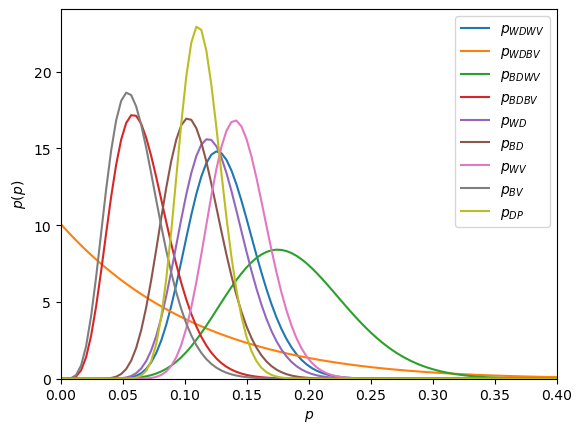

In [57]:
prob_list = [p_wdwv, p_wdbv, p_bdwv, p_bdbv, p_wd, p_bd, p_wv, p_bv, p_DP]
labels = [r'$p_{WDWV}$', r'$p_{WDBV}$', r'$p_{BDWV}$', r'$p_{BDBV}$', r'$p_{WD}$', r'$p_{BD}$', r'$p_{WV}$', r'$p_{BV}$', r'$p_{DP}$']
norms = []
for i, prob in enumerate(prob_list):
    normalization = np.trapz(prob, ps)
    norms.append(normalization)
    prob /= normalization
    plt.plot(ps, prob, label=labels[i])
plt.xlabel(r'$p$')
plt.ylabel(r'$p(p)$')
plt.legend()
plt.xlim(0, 0.4)
plt.ylim(0,)

$$
p(p_{WDWV}, p_{WDBV}, p_{BDBV}, p_{BDWV} | data, DV) = \frac{P(19 | 151, p_{WDWV})P(0 | 9, p_{WDBV})P(11 | 63, p_{BDWV})P(6 | n=103, p=p_{BDBV})p(p_{WDWV}) p(p_{WDBV}) p(p_{BDBV}) p(p_{BDWV})}{p(data | DV)},$$
where $$p(p_{i}) = 1, p \in [0,1]$$
$$
\begin{align}
p(data | DV) &= \int P(19 | 151, p_{WDWV})P(0 | 9, p_{WDBV})P(11 | 63, p_{BDWV})P(6 | n=103, p=p_{BDBV})p(p_{WDWV}) p(p_{WDBV}) p(p_{BDBV}) p(p_{BDWV})dp_{WDWV} dp_{WDBV}dp_{BDBV}dp_{BDWV})\\
p(data | DV) &= \int P(19 | 151, p_{WDWV})p(p_{WDWV})dp_{WDWV} \int P(0 | 9, p_{WDBV})p(p_{WDBV}) dp_{WDBV} \times \\
&\int P(11 | 63, p_{BDWV})p(p_{BDBV})dp_{BDBV} \int P(6 | n=103, p=p_{BDBV})p(p_{BDWV})dp_{BDWV}
\end{align}
$$

In [58]:
ev_H11 = np.prod(norms[:4])
ev_H01 = np.prod(norms[6:8])
ev_H10 = np.prod(norms[4:6])
ev_H00 = norms[8]
print(np.log(ev_H11), np.log(ev_H01), np.log(ev_H10), np.log(ev_H00))

-16.135760860239465 -10.098025854872878 -10.199398177401221 -5.789960170897254


#### Change prior

In [59]:
loc = 0
scale = 0.1
a_trunc = 0
b_trunc = 1
a, b = (a_trunc - loc) / scale, (b_trunc - loc) / scale

(0.0, 24.9828267456771)

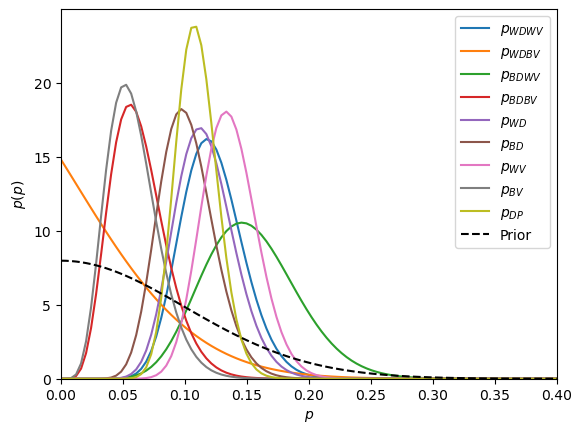

In [60]:
prior = truncnorm.pdf(ps, a, b, loc=loc, scale=scale)
norms_tn = []
for i, prob in enumerate(prob_list):
    integrand = prob*prior
    normalization = np.trapz(integrand, ps)
    norms.append(normalization)
    integrand /= normalization
    plt.plot(ps, integrand, label=labels[i])
plt.plot(ps, prior, label='Prior', ls='--', color='k')
plt.xlabel(r'$p$')
plt.ylabel(r'$p(p)$')
plt.legend()
plt.xlim(0, 0.4)
plt.ylim(0,)

In [61]:
ev_H11 = np.prod(norms[:4])
ev_H01 = np.prod(norms[6:8])
ev_H10 = np.prod(norms[4:6])
ev_H00 = norms[8]
print(np.log(ev_H11), np.log(ev_H01), np.log(ev_H10), np.log(ev_H00))

-16.135760860239465 -10.098025854872878 -10.199398177401221 -5.789960170897254


### Problem 2
- Load in this file with some timeseries data:
```
time, data = np.loadtxt('problem2_data.txt', skiprows=1, unpack=True)
```
- Is the data better fit by a sine or a line? Determine by calculating evidences. Make sure to adjust priors ranges as needed so that there is no posterior railing. Use a uniform prior for $c \in [2,4]$ for both analyses, and assume white Gaussian noise with unit variance as above.
- Now, check whether the noise properties are misspecified (i.e., make the CDF plot above for the model you found to be preferred). For simplicity, keep c fixed to $c=2.5$ and just infer the other free parameter for this step. Is there a model misspecification?
- Now repeat the inference with the preferred model, but fit for the noise properties simulatenously (i.e., make $\sigma$ in the likelihood a free parameter). Make a corner plot of the posteriors on $A/m, c, \sigma$. Re-generate the CDF plot, but this time compare the data CDF to the apropriate noise model CDF given your inference. Is there still a model misspecification?

### Solution

In [62]:
time, data = np.loadtxt('problem2_data.txt', skiprows=1, unpack=True)

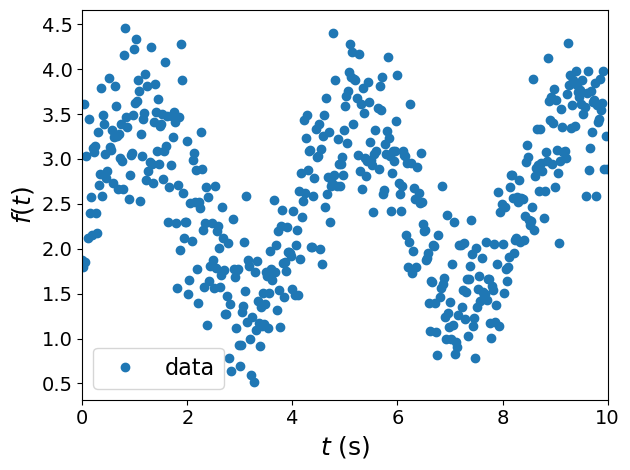

In [63]:
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("$t$ (s)", fontsize=18)
ax.set_ylabel("$f(t)$", fontsize=18)
ax.set_xlim(0,10)
ax.legend(fontsize=16)
plt.tight_layout()

### Sine analysis, $\sigma=1$

In [64]:
As = np.linspace(1.45, 1.55, 100)
dA = As[1] - As[0]
cs = np.linspace(2, 3, 99)
dc = cs[1] - cs[0]
prior_A = 1./(As[-1]-As[0])
prior_c = 1./(cs[-1]-cs[0])

In [65]:
likelihoods_sine = []
for A in As:
    for c in cs:
        likelihoods_sine.append(likelihood_sine(data, time, A, c, 1))
likelihoods_sine = np.array(likelihoods_sine).reshape(len(As), len(cs))

In [66]:
likelihoods_sine

array([[3.35481340e-255, 3.86843823e-254, 4.23440975e-253, ...,
        2.30647468e-256, 1.79575872e-257, 1.32720250e-258],
       [5.68280853e-255, 6.53321937e-254, 7.12986612e-253, ...,
        2.92919031e-256, 2.27375570e-257, 1.67544404e-258],
       [9.54230705e-255, 1.09375937e-253, 1.19009082e-252, ...,
        3.69351219e-256, 2.85851142e-257, 2.10005294e-258],
       ...,
       [1.00488095e-251, 9.70282360e-251, 8.89347681e-250, ...,
        2.75012653e-260, 1.79295006e-261, 1.10961835e-262],
       [6.79468133e-252, 6.55836197e-251, 6.00912986e-250, ...,
        1.79602596e-260, 1.17049859e-261, 7.24134257e-263],
       [4.54899965e-252, 4.38934103e-251, 4.02043146e-250, ...,
        1.16504868e-260, 7.59030952e-262, 4.69423490e-263]])

In [67]:
posterior_sine = likelihoods_sine*prior_A*prior_c
norm_sine = np.trapz(np.trapz(posterior_sine, cs, axis=1), As)
posterior_sine /= norm_sine
print(np.log(norm_sine))

-521.2179691265983


In [68]:
post_A = np.trapz(posterior_sine, cs, axis=1)
post_c = np.trapz(posterior_sine, As, axis=0)

In [69]:
lmax, l50, l90 = calc_L90_L50(dA, dc, posterior_sine)

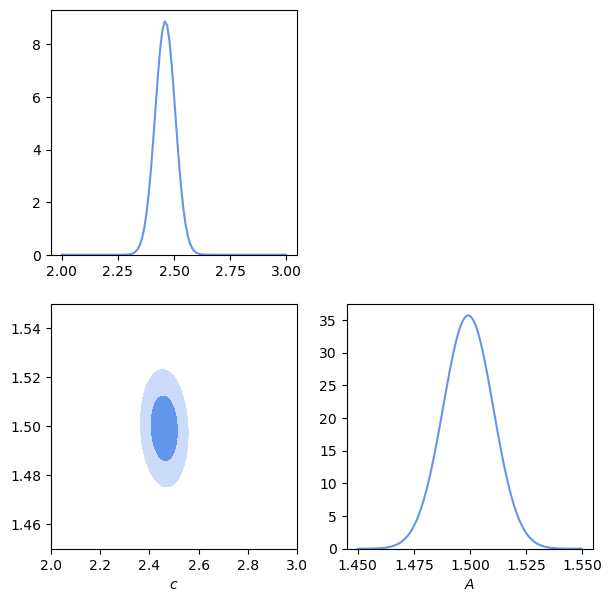

In [70]:
fig, axes = plt.subplots(2,2, figsize=(7,7))
axes[1,1].plot(As, post_A, color='cornflowerblue')
axes[1,1].set_ylim(0,)
axes[0,0].plot(cs, post_c, color='cornflowerblue')
axes[0,0].set_ylim(0,)
axes[1,0].contourf(cs, As, posterior_sine, levels=[l90, l50, lmax], colors=['#CBDBF9', '#6495ED'])
axes[1,0].set_xlabel(r'$c$')
axes[1,1].set_xlabel(r'$A$')
axes[0,1].remove()

### Line analysis, $\sigma=1$

In [71]:
ms = np.linspace(-0.1, 0.1, 100)
dm = ms[1]-ms[0]
prior_m = 1./(ms[-1]-ms[0])

In [72]:
likelihoods_line = []
for m in ms:
    for c in cs:
        likelihoods_line.append(likelihood_line(data, time, m, c, 1))
likelihoods_line = np.array(likelihoods_line).reshape(len(ms), len(cs))

In [73]:
posterior_line = likelihoods_line*prior_m*prior_c
norm_line = np.trapz(np.trapz(posterior_line, cs, axis=1), ms)
posterior_line /= norm_line
print(np.log(norm_line))

-656.3690438014507


In [74]:
post_m = np.trapz(posterior_line, cs, axis=1)
post_c_line = np.trapz(posterior_line, ms, axis=0)

In [75]:
lmax, l50, l90 = calc_L90_L50(dm, dc, posterior_line)

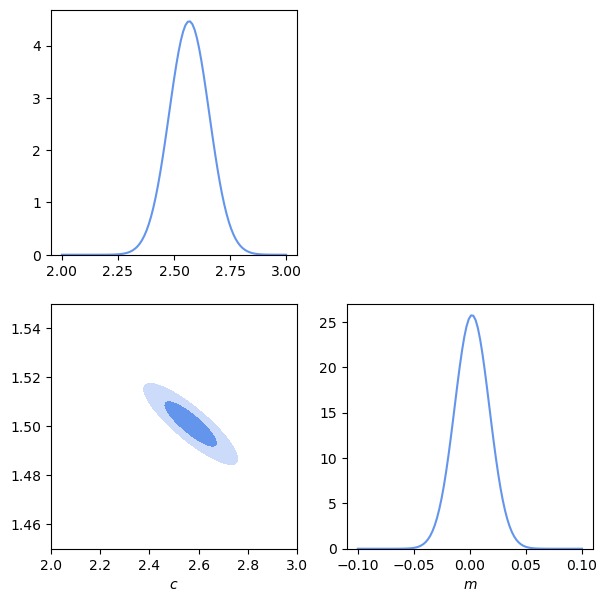

In [76]:
fig, axes = plt.subplots(2,2, figsize=(7,7))
axes[1,1].plot(ms, post_m, color='cornflowerblue')
axes[1,1].set_ylim(0,)
axes[0,0].plot(cs, post_c_line, color='cornflowerblue')
axes[0,0].set_ylim(0,)
axes[1,0].contourf(cs, As, posterior_line, levels=[l90, l50, lmax], colors=['#CBDBF9', '#6495ED'])
axes[1,0].set_xlabel(r'$c$')
axes[1,1].set_xlabel(r'$m$')
axes[0,1].remove()

Which model is preferred?

In [77]:
lnBF = np.log(norm_sine) - np.log(norm_line)
print(lnBF)

135.15107467485245


Check for model misspecification

In [79]:
# Fit A and keep c fixed to its maximum-posterior value from the run with both
likelihood_A1d = []
for A in As:
    likelihood_A1d.append(likelihood_sine(data, time, A, 2.5, 1))
posterior_A1d = np.array(likelihood_A1d)*prior_A

In [80]:
norm_A1d = np.trapz(posterior_A1d, As)
posterior_A1d /= norm_A1d
cdf_A1d = cumulative_trapezoid(posterior_A1d, As, initial=0)

In [81]:
unit_cube_samples = np.random.rand(1000)
inverse_cdf_samples = np.interp(unit_cube_samples, cdf_A1d, As)

(array([ 2.64446839,  1.3222342 ,  2.20372366,  1.76297893,  8.37414992,
         9.25563938,  8.81489465, 20.27425769, 19.83351296, 26.44468394,
        21.59649189, 31.73362073, 33.49659966, 34.81883386, 31.292876  ,
        37.90404699, 36.14106806, 25.12244975, 26.00393921, 18.51127876,
        12.78159724,  9.25563938,  7.93340518,  4.40744732,  3.08521313,
         2.64446839,  2.20372366,  0.        ,  0.44074473,  0.44074473]),
 array([1.46660314, 1.46887203, 1.47114091, 1.4734098 , 1.47567869,
        1.47794757, 1.48021646, 1.48248535, 1.48475424, 1.48702312,
        1.48929201, 1.4915609 , 1.49382978, 1.49609867, 1.49836756,
        1.50063645, 1.50290533, 1.50517422, 1.50744311, 1.50971199,
        1.51198088, 1.51424977, 1.51651865, 1.51878754, 1.52105643,
        1.52332532, 1.5255942 , 1.52786309, 1.53013198, 1.53240086,
        1.53466975]),
 [<matplotlib.patches.Polygon at 0x16c586020>])

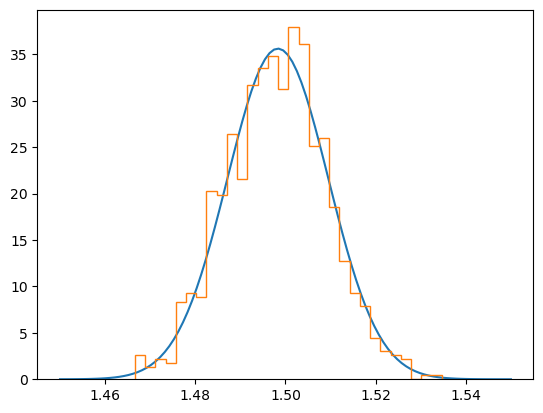

In [82]:
plt.plot(As, posterior_A1d)
plt.hist(inverse_cdf_samples, density=True, histtype='step', bins=30)

Text(0, 0.5, 'data CDF - model CDF')

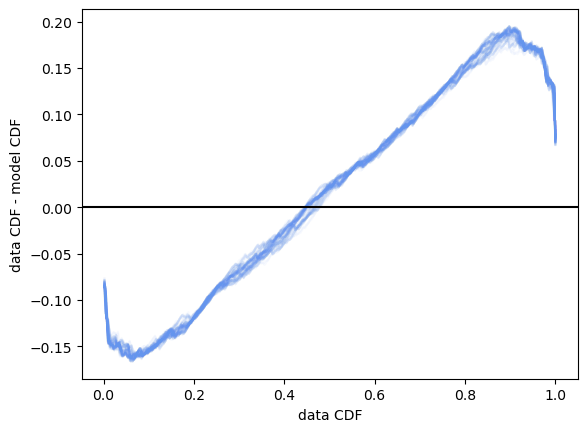

In [84]:
for i in inverse_cdf_samples[::10]:
    model = sine(time, i, 2.5)
    residual = data - model
    data_cdf = np.arange(1,len(residual)+1)/len(residual)
    model_cdf = norm.cdf(np.sort(residual))
    diff = data_cdf - model_cdf
    plt.plot(data_cdf, diff, color='cornflowerblue', alpha=0.05)
plt.axhline(0, color='k')
plt.xlabel('data CDF')
plt.ylabel('data CDF - model CDF')

Rerun in 3D

In [85]:
sigmas = np.linspace(0.25, 0.75, 101)
prior_sig = 1./(sigmas[-1]-sigmas[1])
likelihoods_3d = []
for A in As:
    for c in cs:
        for sigma in sigmas:
            likelihoods_3d.append(likelihood_sine(data, time, A, c, sigma))
likelihoods_3d = np.array(likelihoods_3d).reshape(len(As), len(cs), len(sigmas))

In [86]:
dsig = sigmas[1] - sigmas[0]

In [87]:
posterior_3d = likelihoods_3d * prior_A * prior_c * prior_sig
norm_3d = np.trapz(np.trapz(np.trapz(posterior_3d, As, axis=0), cs, axis=0), sigmas)
posterior_3d /= norm_3d
print(np.log(norm_3d))

-352.9205516169002


In [88]:
# calculate marginalized 2D and 1D posteriors
post_Ac = np.trapz(posterior_3d, sigmas, axis=2)
post_csig = np.trapz(posterior_3d, As, axis=0)
post_Asig = np.trapz(posterior_3d, cs, axis=1)
post_A = np.trapz(post_Ac, cs, axis=1)
post_c = np.trapz(post_Ac, As, axis=0)
post_sig = np.trapz(post_csig, cs, axis=0)

In [89]:
# calculate 90 and 50% credible intervals for all 2D posteriors
lmax_Ac, l50_Ac, l90_Ac = calc_L90_L50(dA, dc, post_Ac)
lmax_csig, l50_csig, l90_csig = calc_L90_L50(dc, dsig, post_csig)
lmax_Asig, l50_Asig, l90_Asig = calc_L90_L50(dA, dsig, post_Asig)

In [90]:
posts_1d = [post_A, post_c, post_sig]
inds_1d = [As, cs, sigmas]

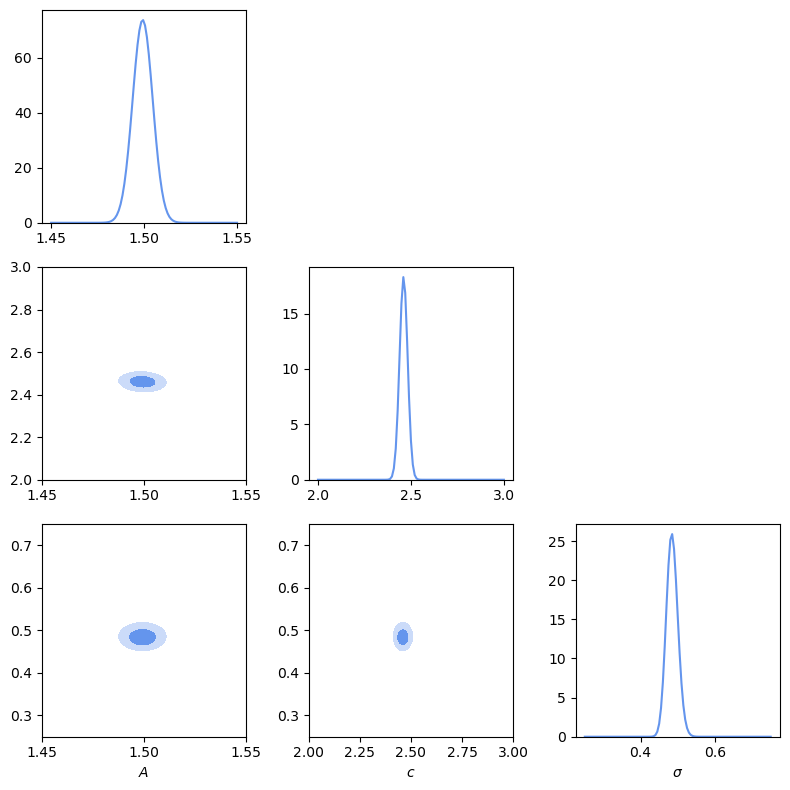

In [91]:
N=3
fig, axes = plt.subplots(N,N, figsize=(8,8))
axes_2d = [axes[1,0], axes[2,0], axes[2,1]]
for i, post in enumerate(posts_1d):
    axes[i,i].plot(inds_1d[i], posts_1d[i], color='cornflowerblue')
    axes[i,i].set_ylim(0,)
axes[1,0].contourf(As, cs, post_Ac.T, levels=[l90_Ac, l50_Ac, lmax_Ac], colors=['#CBDBF9', '#6495ED'])
axes[2,0].contourf(As, sigmas, post_Asig.T, levels=[l90_Asig, l50_Asig, lmax_Asig], colors=['#CBDBF9', '#6495ED'])
axes[2,1].contourf(cs, sigmas, post_csig.T, levels=[l90_csig, l50_csig, lmax_csig], colors=['#CBDBF9', '#6495ED'])
axes[2,2].set_xlabel(r'$\sigma$')
axes[2,1].set_xlabel(r'$c$')
axes[2,0].set_xlabel(r'$A$')
for axis in [axes[0,1], axes[0,2], axes[1,2]]:
    axis.remove()
plt.tight_layout()

Check for model misspecification

In [92]:
sig_best = sigmas[np.argmax(post_sig)]
cmax_new = cs[np.argmax(post_c)]
print(sig_best, cmax_new)

0.485 2.4591836734693877


In [98]:
# Fit A and keep c fixed to its maximum-posterior value from the run with both
likelihood_A1d = []
for A in As:
    likelihood_A1d.append(likelihood_sine(data, time, A, 2.5, 0.5))
posterior_A1d = np.array(likelihood_A1d)*prior_A

In [99]:
norm_A1d = np.trapz(posterior_A1d, As)
posterior_A1d /= norm_A1d
cdf_A1d = cumulative_trapezoid(posterior_A1d, As, initial=0)

In [100]:
unit_cube_samples = np.random.rand(5000)
inverse_cdf_samples = np.interp(unit_cube_samples, cdf_A1d, As)

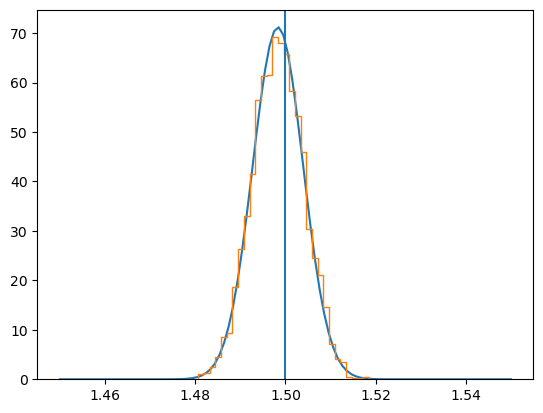

In [103]:
plt.plot(As, posterior_A1d)
plt.hist(inverse_cdf_samples, density=True, histtype='step', bins=30)
plt.axvline(1.5)

Build the CDF difference plot conceptually, piece by piece. First, we plot the PDF of the residual, which should be Gaussian distributed with $\sigma=0.5$.

Text(0, 0.5, 'pdf(Residual)')

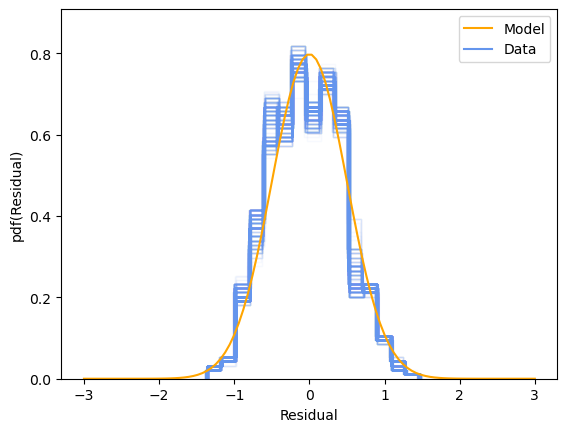

In [128]:
# also check the PDFs by eye
for i in inverse_cdf_samples[::10]:
    model = sine(time, i, 2.5)
    residual = data - model
    plt.hist(residual, bins=15, histtype='step',color='cornflowerblue', density=True, alpha=0.05)
x = np.linspace(-3, 3, 100)
plt.plot(x, norm.pdf(x, scale=0.5), color='orange', label='Model')
plt.axhline(-1, color='cornflowerblue', label='Data')
plt.legend()
plt.ylim(0,)
plt.xlabel('Residual')
plt.ylabel('pdf(Residual)')

Next, we look at the CDFs of the residuals, which should follow the CDFs for a Gaussian with $\sigma=0.05$.

Text(0, 0.5, 'cdf(Residual)')

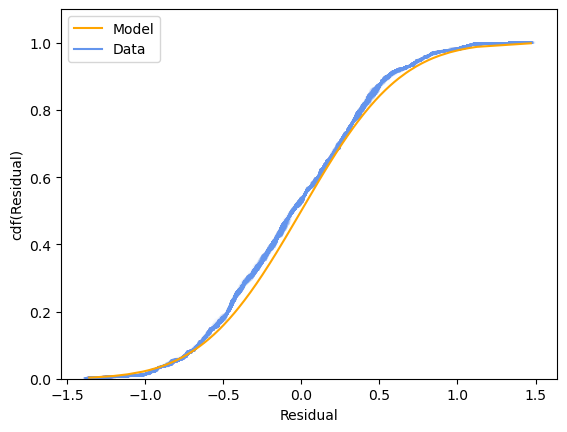

In [129]:
# also check the CDFs by eye
for i in inverse_cdf_samples[::10]:
    model = sine(time, i, 2.5)
    residual = data - model
    data_cdf = np.arange(1,len(residual)+1)/len(residual)
    plt.plot(np.sort(residual), data_cdf, color='cornflowerblue', alpha=0.05)
plt.plot(np.sort(residual), norm.cdf(np.sort(residual), scale=0.5), color='orange', label='Model')
plt.axhline(-1, color='cornflowerblue', label='Data')
plt.ylim(0,)
plt.legend()
plt.xlabel('Residual')
plt.ylabel('cdf(Residual)')

The CDF values themselves should be uniformly distributed on the unit interval, for both the data (by definition) and the model, assuming that the data are well-described by the model.

Text(0, 0.5, 'pdf(cdf(Residual))')

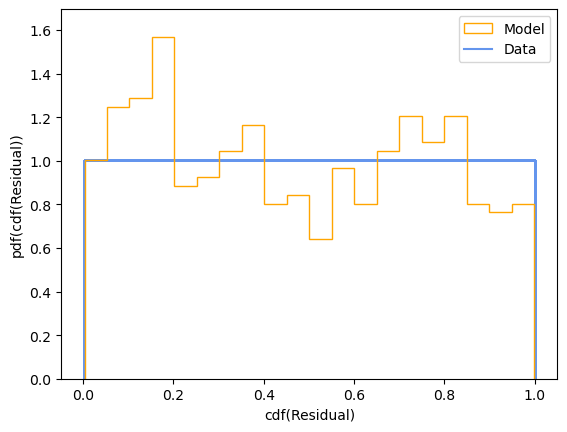

In [131]:
# also check the CDFs by eye
for i in inverse_cdf_samples[::10]:
    model = sine(time, i, 2.5)
    residual = data - model
    data_cdf = np.arange(1,len(residual)+1)/len(residual)
    plt.hist(data_cdf, color='cornflowerblue', alpha=0.05, histtype='step', density=True, bins=20)
plt.hist(norm.cdf(residual, scale=0.5), color='orange', histtype='step', density=True, bins=20, label='Model')
plt.axhline(-1, color='cornflowerblue', label='Data')
plt.ylim(0,)
plt.legend()
plt.xlabel('cdf(Residual)')
plt.ylabel('pdf(cdf(Residual))')

Text(0, 0.5, 'data CDF - model CDF')

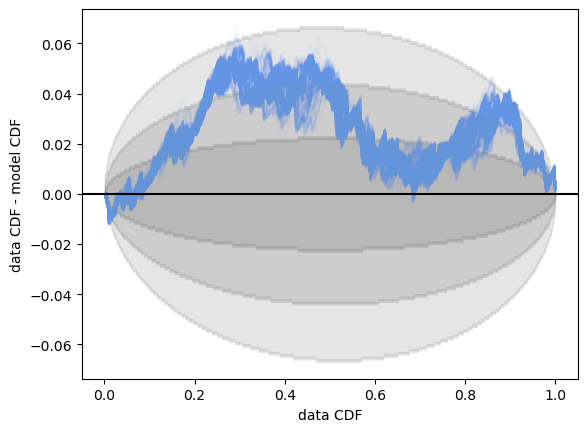

In [115]:
for i in inverse_cdf_samples[::10]:
    model = sine(time, i, 2.5)
    residual = data - model
    data_cdf = np.arange(1,len(residual)+1)/len(residual)
    model_cdf = norm.cdf(np.sort(residual), scale=0.5)
    diff = data_cdf - model_cdf
    plt.plot(data_cdf, diff, color='cornflowerblue', alpha=0.05)

# add uncertainty regions
x_values = np.linspace(0, 1, 1001)
N = len(residual)
confidence_interval = [0.68, 0.95, 0.997] #1,2,3 sigma
confidence_interval_alpha = [0.1] * len(confidence_interval)
for ci, alpha in zip([0.68, 0.95, 0.997], confidence_interval_alpha):
        edge_of_bound = (1. - ci) / 2.
        # order statistics
        lower = binom.ppf(1 - edge_of_bound, N, x_values) / N - x_values
        upper = binom.ppf(edge_of_bound, N, x_values) / N - x_values
        # The binomial point percent function doesn't always return 0 @ 0,
        # so set those bounds explicitly to be sure
        lower[0] = 0
        upper[0] = 0
        plt.fill_between(x_values, lower, upper, alpha=alpha, color='k')    
plt.axhline(0, color='k')
plt.xlabel('data CDF')
plt.ylabel('data CDF - model CDF')